In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2
import pandas as pd
import sys
path = "/nasbrain/f21lin/venv/venvDuSchlag/lib/python3.10/site-packages/"
if path not in sys.path:
    sys.path.append(path)
from segment_anything import sam_model_registry,SamAutomaticMaskGenerator

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.4) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [1]])
        img[m] = color_mask
    ax.imshow(img)

In [3]:
miniImageNetPath = "/nasbrain/datasets/miniimagenetimages"
test_csv = pd.read_csv(miniImageNetPath+"/test.csv")

In [4]:
sam = sam_model_registry["vit_l"](checkpoint="/nasbrain/f21lin/sam_vit_l_0b3195.pth")
sam.to("cuda")
sam.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-23): 24 x Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1024, out_features=4096, bias=True)
          (lin2): Linear(in_features=4096, out_features=1024, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

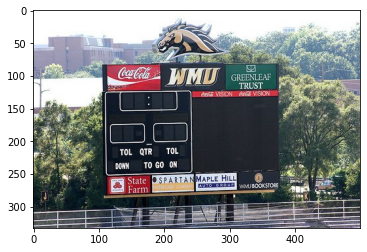

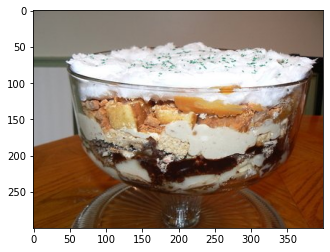

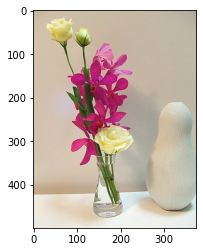

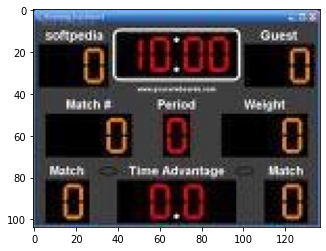

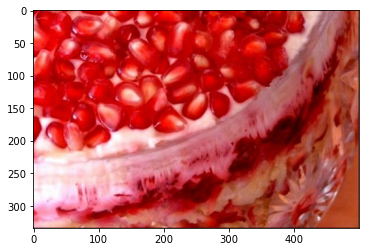

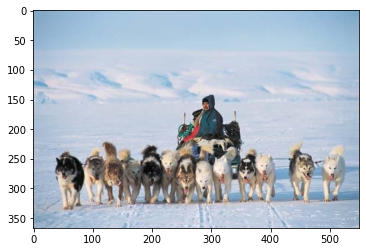

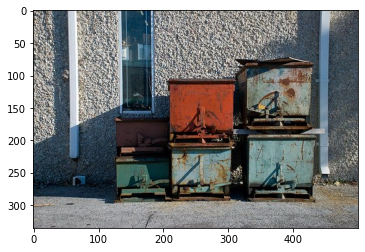

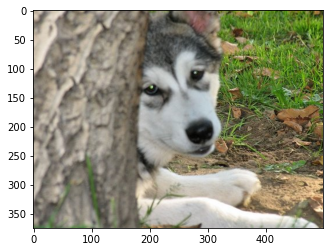

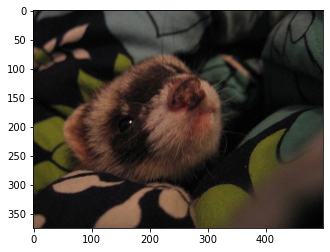

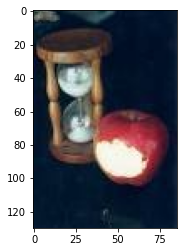

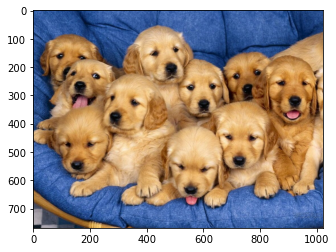

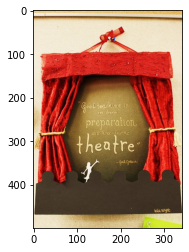

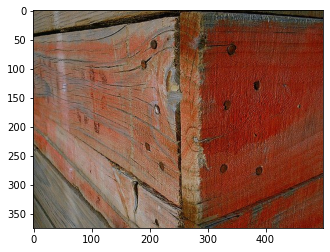

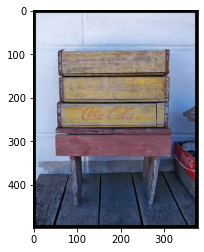

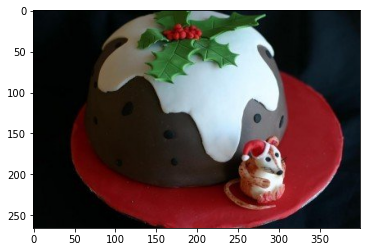

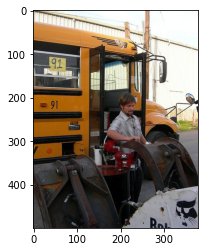

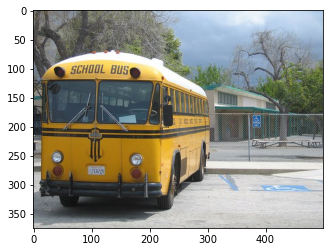

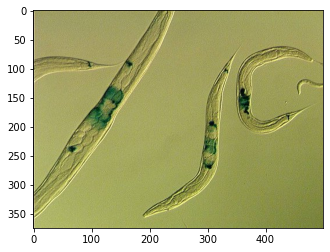

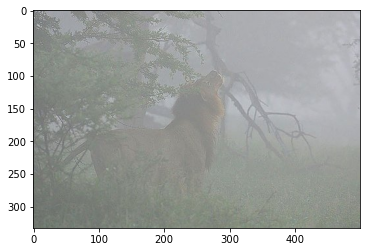

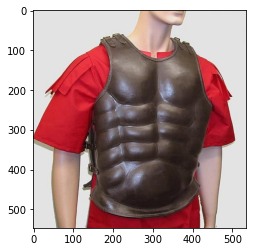

In [5]:
image_paths = miniImageNetPath+"/images/"+test_csv.sample(20)["filename"]
images = []
for image_path in image_paths:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    images.append(image)
    plt.imshow(image)
    plt.show()

In [10]:
mask_generator = SamAutomaticMaskGenerator(sam,points_per_side=4,stability_score_thresh=0.1)

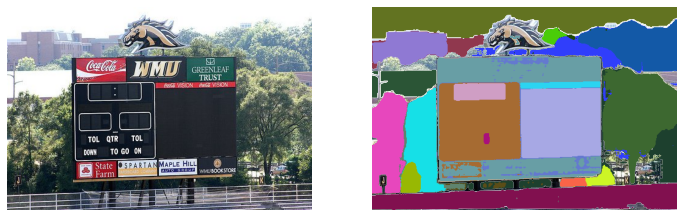

(333, 500, 3)


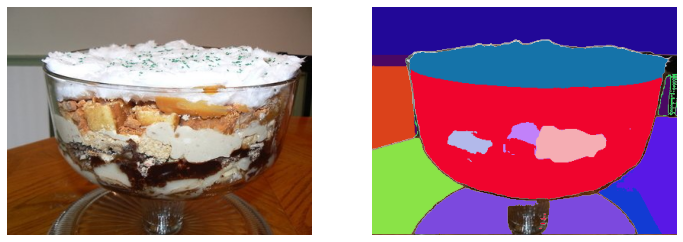

(300, 400, 3)


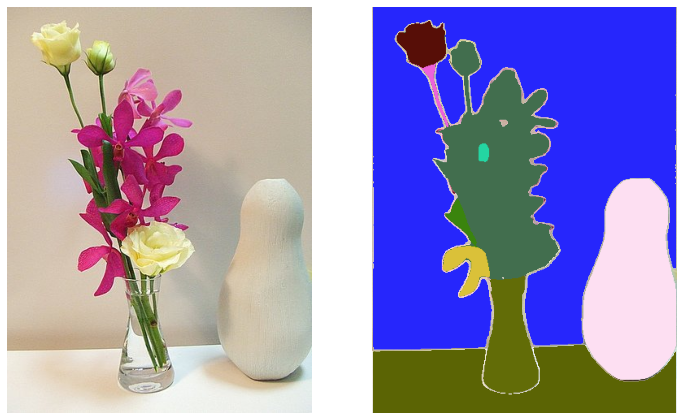

(500, 375, 3)


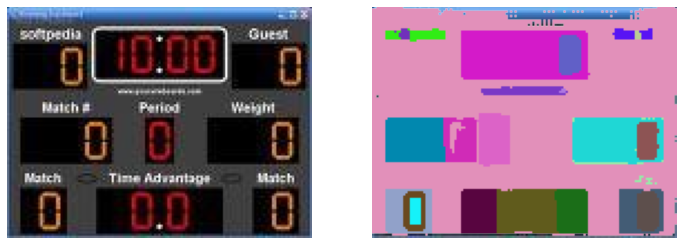

(104, 137, 3)


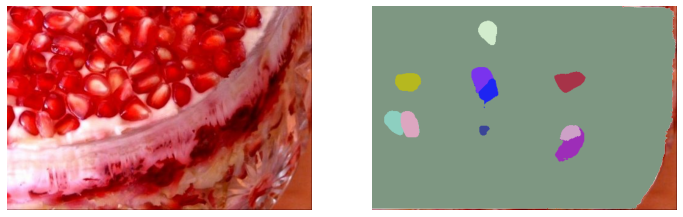

(334, 500, 3)


In [ ]:
torch.cuda.empty_cache()
threshold = 0.3

with torch.inference_mode():
    for image in images:
        height,width,_ = image.shape
        masks = mask_generator.generate(image)
        fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,9))
        ax1.imshow(image)
        ax1.axis("off")
        ax2.imshow(image)
        show_anns(masks)
        ax2.axis("off")
        plt.show()
        print(image.shape)
print("Done")


(372, 296, 3)
(165, 132, 3)


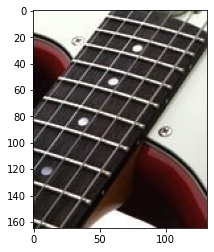

(138, 130, 3)


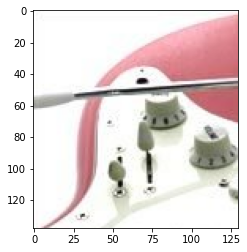

(129, 270, 3)


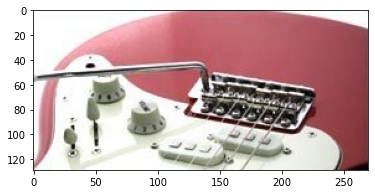

(112, 89, 3)


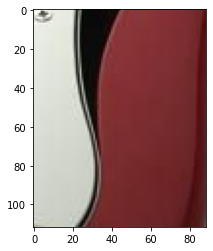

(165, 91, 3)


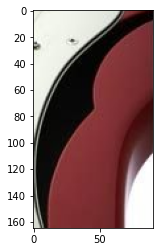

(112, 89, 3)


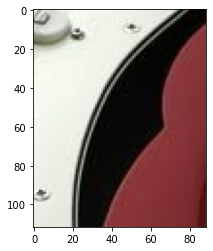

(112, 89, 3)


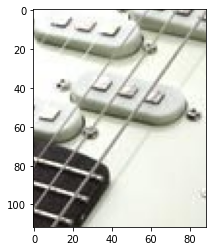

7


In [28]:
print(image.shape)

cropped_images = []
threshold = 0.3
for mask in masks:
    bbox = mask["bbox"]
    crop_width = bbox[2]
    crop_height = bbox[3]
    if crop_width/width < threshold:
        crop_width = threshold*width
    if crop_height/height < threshold:
        crop_height = threshold*height
    ylim = round(min(bbox[1]+crop_height,image.shape[0]))
    xlim = round(min(bbox[0]+crop_width,image.shape[1]))
    crop = image[round(bbox[1]):ylim,round(bbox[0]):xlim,:]
    print(crop.shape)
    plt.imshow(crop)
    plt.show()
    cropped_images.append(crop)
print(len(cropped_images))